# 1

In [ ]:
# Import libraries
import geopandas as gpd
import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from os import listdir
import glob
import re
from rasterio.features import geometry_mask
from matplotlib.colors import ListedColormap

# 2

In [ ]:
# Paths to the Sentinel-1 radar images
tile_1_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\Sentinel-1_CSAR\EQUI7_EU010M\E052N015T1'
tile_2_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\Sentinel-1_CSAR\EQUI7_EU010M\E053N015T1'

# Load shapefiles with Geopandas
sampling_points_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\shapefiles\shapefiles\sampling_points.shp'
reed_belt_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\shapefiles\shapefiles\reed_belt.shp'

# Load shapefiles into geopandas dataframes
sampling_points = gpd.read_file(sampling_points_path)
reed_belt = gpd.read_file(reed_belt_path)

# Reproject to match the same crs
radar_crs = "EPSG:27704"
sampling_points = sampling_points.to_crs(radar_crs)
reed_belt = reed_belt.to_crs(radar_crs)

print("Sampling Points CRS after reprojection:", sampling_points.crs)
print("Reed Belt CRS after reprojection:", reed_belt.crs)
print(sampling_points.head())
print(reed_belt.head())

Sampling Points CRS after reprojection: EPSG:27704
Reed Belt CRS after reprojection: EPSG:27704
   id          layer                                               path  \
0   0  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
1   1  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
2   2  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
3   3  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
4   4  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   

                          geometry  
0   POINT (5295821.275 1582403.47)  
1  POINT (5296377.898 1570565.116)  
2                             None  
3  POINT (5289119.881 1553625.521)  
4  POINT (5294107.786 1583957.137)  
                 id               @id       area  FID  \
0   relation/409669   relation/409669  164182545    0   
1  relation/2251752  relation/2251752       4485    1   
2  relation/3010768  relation/3010768     308419    2   
3  

In [ ]:
# just checking one random .tif file to check they have the same geoprojection 
radar_file_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\Sentinel-1_CSAR\EQUI7_EU010M\E052N015T1\GMR40_20190210T164223__VH_A073_E052N015T1_EU010M_V1M0R01_S1AIWGRDH.tif'

with rasterio.open(radar_file_path) as src:
    radar_crs = src.crs  # Get the CRS of the radar image
    print("Radar Data CRS:", radar_crs)

# compare the shapefiles
print("Shapefile CRS (sampling points):", sampling_points.crs)
print("Shapefile CRS (reed belt):", reed_belt.crs)

Radar Data CRS: EPSG:27704
Shapefile CRS (sampling points): EPSG:27704
Shapefile CRS (reed belt): EPSG:27704


# 3

In [ ]:
# extract the year and month from filename in the format YYYYMMDD (all of the measurements were taken in the same month)
def extract_date_month_from_filename(filename):
    match = re.search(r'(\d{4})(\d{2})\d{2}T', filename)
    if match:
        year = match.group(1)
        month = match.group(2)
        return year, month
    return None, None

# Merge both parts of the same tile
def load_and_merge_tile(tile_path, polarization, months_of_interest=["02", "05", "08", "11"]):
    tile_files = sorted(glob.glob(f"{tile_path}/*{polarization}*.tif"))
    
    combined_images = []
    combined_dates = []
    
    for i in range(0, len(tile_files), 2):
        # north and south parts of a single date/day
        north_file = tile_files[i]
        south_file = tile_files[i + 1]
        
        year, month = extract_date_month_from_filename(north_file)
        if month in months_of_interest:
            # Merge north and south 
            with rasterio.open(north_file) as src1, rasterio.open(south_file) as src2:
                tile_data, _ = merge([src1, src2])
                
            # Append files
            combined_images.append(tile_data[0])  
            combined_dates.append(f"{year}-{month}")
    
    return np.array(combined_images), combined_dates

# Load and merge VH data within each tile
vh_tile_1, dates = load_and_merge_tile(tile_1_path, 'VH')
vh_tile_2, _ = load_and_merge_tile(tile_2_path, 'VH')

# same but for VV data 
vv_tile_1, _ = load_and_merge_tile(tile_1_path, 'VV')
vv_tile_2, _ = load_and_merge_tile(tile_2_path, 'VV')

# just to check the shapes match
print("VH Tile 1 Shape:", vh_tile_1.shape)  
print("VH Tile 2 Shape:", vh_tile_2.shape)  
print("Dates Loaded:", dates)

VH Tile 1 Shape: (16, 10000, 10000)
VH Tile 2 Shape: (16, 10000, 10000)
Dates Loaded: ['2019-02', '2019-05', '2019-08', '2019-11', '2020-02', '2020-05', '2020-08', '2020-11', '2021-02', '2021-05', '2021-08', '2021-11', '2022-02', '2022-05', '2022-08', '2022-11']


# 4

In [ ]:
# Concatenate left (Tile 1) and right (Tile 2) for VH and VV across all time steps
vh_series = np.concatenate((vh_tile_1, vh_tile_2), axis=2)  
vv_series = np.concatenate((vv_tile_1, vv_tile_2), axis=2)  

### 4.1 

In [ ]:
# check the shape to make sure it´s correct
print("VH Series Shape after squeezing:", vh_series.shape)
print("VV Series Shape after squeezing:", vv_series.shape)

VH Series Shape after squeezing: (16, 10000, 20000)
VV Series Shape after squeezing: (16, 10000, 20000)


# 5

In [ ]:
# CR and mask empty values
def calculate_cr(vh_series, vv_series):
    vh_series = np.ma.masked_where(vh_series == -9999, vh_series)
    vv_series = np.ma.masked_where(vv_series == -9999, vv_series)
    cr_series = vh_series - vv_series
    return cr_series

cr_series = calculate_cr(vh_series, vv_series)

# Check the shape of CR
print("CR Series Shape:", cr_series.shape)


CR Series Shape: (16, 10000, 20000)


In [10]:
# Check the range of CR values across all time steps
print("CR Min:", np.nanmin(cr_series))
print("CR Max:", np.nanmax(cr_series))

CR Min: -53
CR Max: 27


# 6

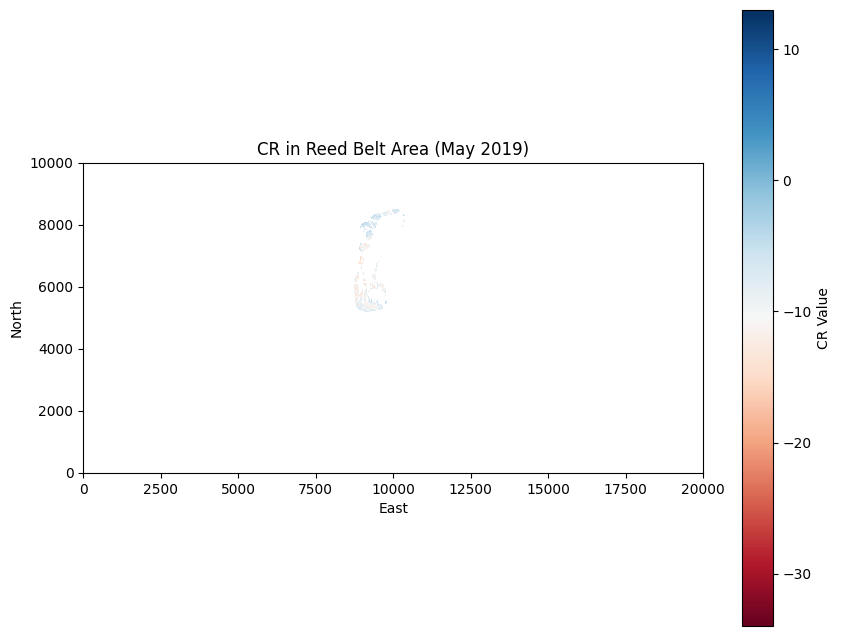

In [ ]:
# Load the geometry of the reed belt as a mask so I just plot the area of the reed belt
reed_belt_geom = [reed_belt.geometry.iloc[0]]  # since the reed_belt is a single polygon

# Define the CR data and transform (use the last time step as an example)
cr_data = cr_series[1]  # I´ll plot may since it´s my birthday month
transform = rasterio.open(glob.glob(f"{tile_1_path}/*VH*.tif")[0]).transform  

mask = geometry_mask(
    reed_belt_geom,
    transform=transform,
    invert=True,  # i just keep the reed belt area
    out_shape=cr_data.shape
)

# Apply mask to CR data
cr_masked = np.ma.masked_array(cr_data, mask=~mask)  

plt.figure(figsize=(10, 8))
plt.imshow(cr_masked, cmap='RdBu', extent=[0, 20000, 0, 10000])
plt.title("CR in Reed Belt Area (May 2019)")
plt.colorbar(label="CR Value (higher CR means drier areas)")
plt.xlabel("East")
plt.ylabel("North")
plt.show()


# 7

In [ ]:
# extract time series for each sampling point
def extract_time_series_from_points(series, sampling_points, transform):
    time_series_data = []
    for point in sampling_points.geometry:
        # Skip if the geometry is None or invalid
        if point is None or point.is_empty:
            continue
        row, col = ~transform * (point.x, point.y)
        row, col = int(row), int(col)
        # Check bounds
        if 0 <= row < series.shape[1] and 0 <= col < series.shape[2]:
            # time series data at the specified location
            point_series = series[:, row, col]
            time_series_data.append(point_series)
        else:
            print(f"Point ({point.x}, {point.y}) is out of bounds.")
    
    return np.array(time_series_data)

transform = rasterio.open(glob.glob(f"{tile_1_path}/*VV*.tif")[0]).transform

# Extract time series for VH, VV, and CR at the 110 (then 88 valid) sampling points
vh_time_series = extract_time_series_from_points(vh_series, sampling_points, transform)
vv_time_series = extract_time_series_from_points(vv_series, sampling_points, transform)
cr_time_series = extract_time_series_from_points(cr_series, sampling_points, transform)

# Check shapes of extracted data
print("VH Time Series Shape:", vh_time_series.shape)
print("VV Time Series Shape:", vv_time_series.shape)
print("CR Time Series Shape:", cr_time_series.shape)


Point (5017582.041349666, 1482883.6487868957) is out of bounds.
Point (5301366.461397656, 1583962.8276618095) is out of bounds.
Point (5301147.565392705, 1584209.6558220368) is out of bounds.
Point (5118043.310695137, 1450543.650852256) is out of bounds.
Point (5302294.22539038, 1584218.0749297838) is out of bounds.
Point (5024397.281634912, 1624617.8941798094) is out of bounds.
Point (5303255.366205552, 1581199.8271254688) is out of bounds.
Point (5302579.753396288, 1578635.7968579424) is out of bounds.
Point (5017582.041349666, 1482883.6487868957) is out of bounds.
Point (5301366.461397656, 1583962.8276618095) is out of bounds.
Point (5301147.565392705, 1584209.6558220368) is out of bounds.
Point (5118043.310695137, 1450543.650852256) is out of bounds.
Point (5302294.22539038, 1584218.0749297838) is out of bounds.
Point (5024397.281634912, 1624617.8941798094) is out of bounds.
Point (5303255.366205552, 1581199.8271254688) is out of bounds.
Point (5302579.753396288, 1578635.7968579424

# 8

Spatial Clustering for VH - May 2019-05


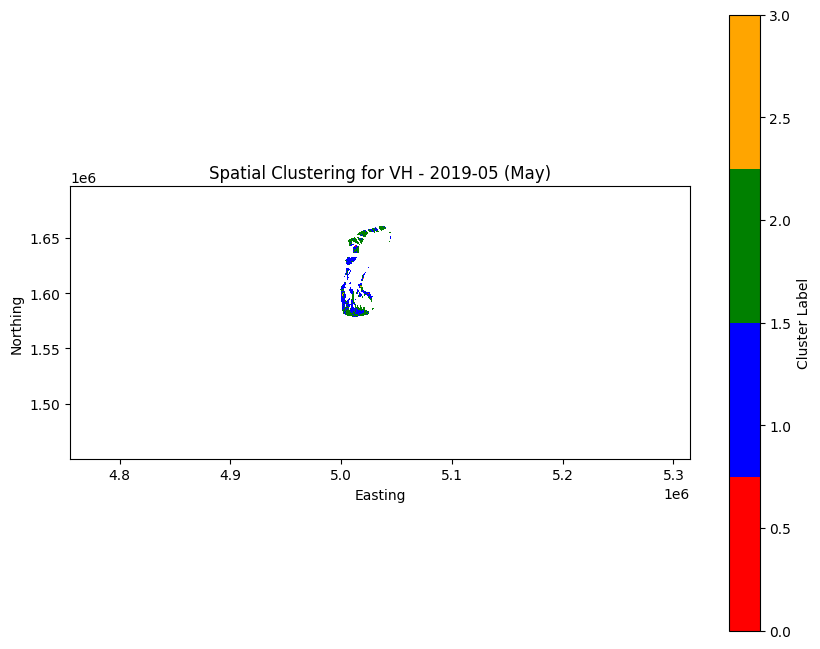

Spatial Clustering for VV - May 2019-05


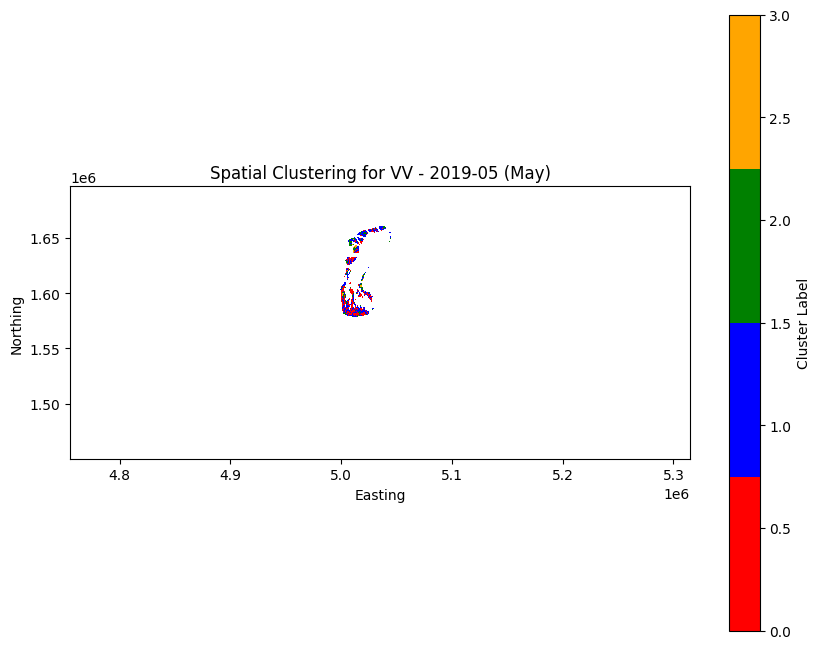

Spatial Clustering for CR - May 2019-05


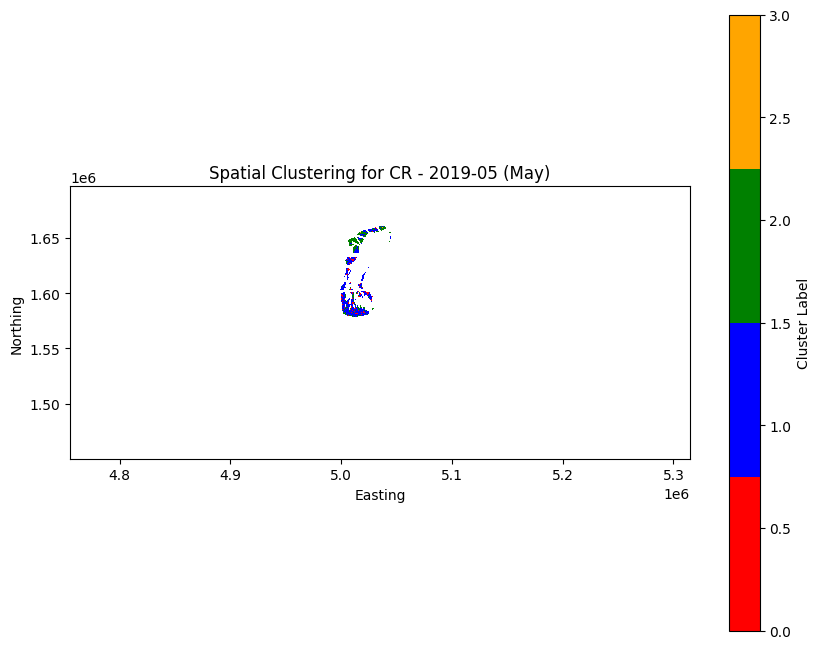

Spatial Clustering for VH - May 2020-05


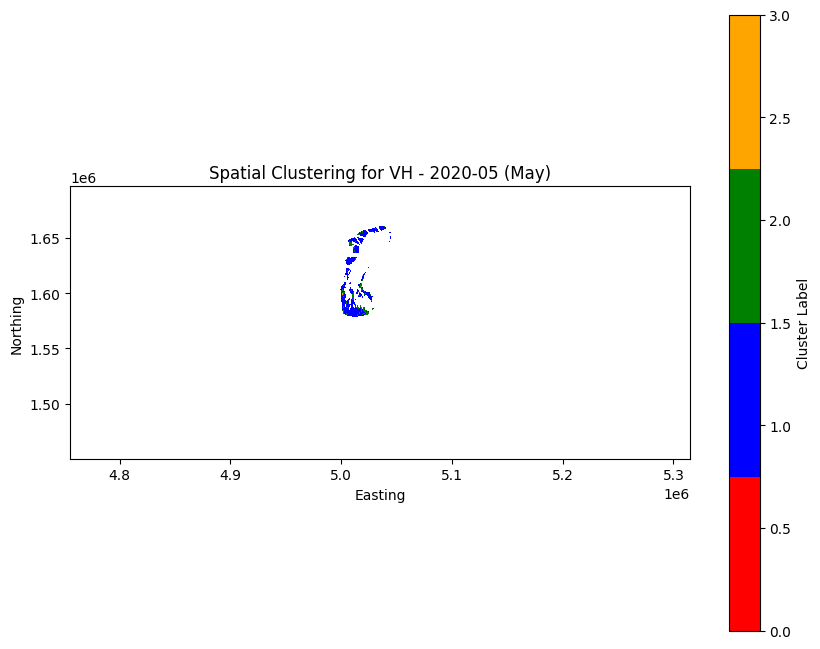

Spatial Clustering for VV - May 2020-05


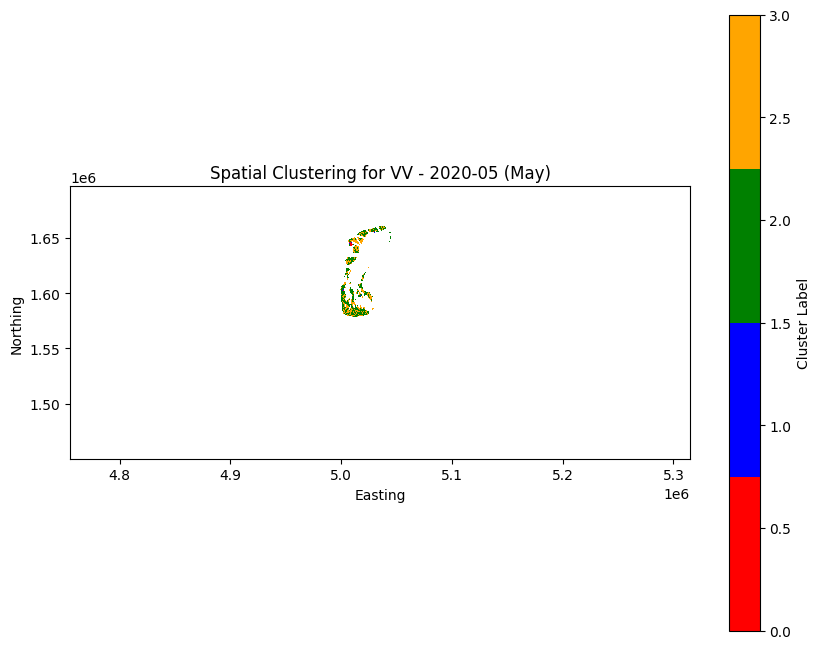

Spatial Clustering for CR - May 2020-05


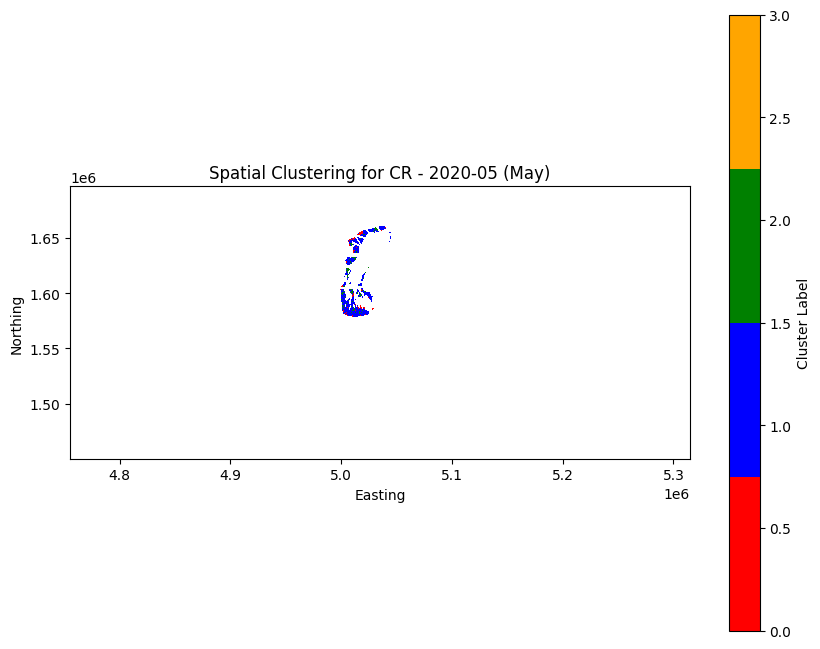

Spatial Clustering for VH - May 2021-05


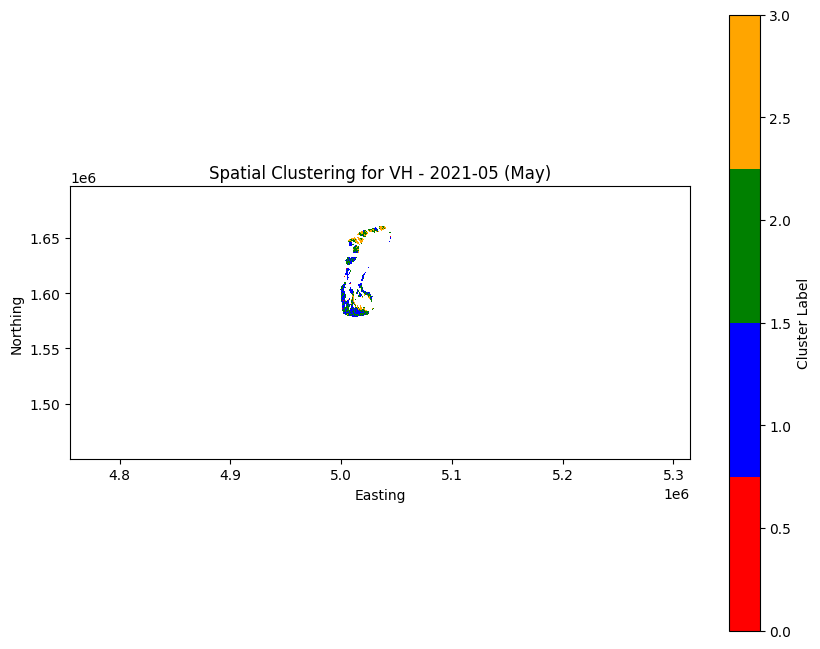

Spatial Clustering for VV - May 2021-05


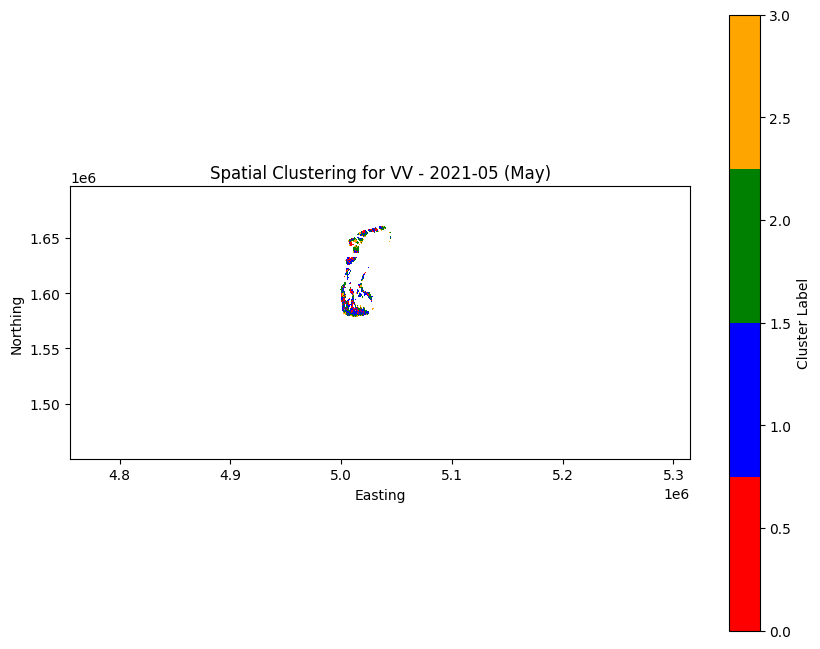

Spatial Clustering for CR - May 2021-05


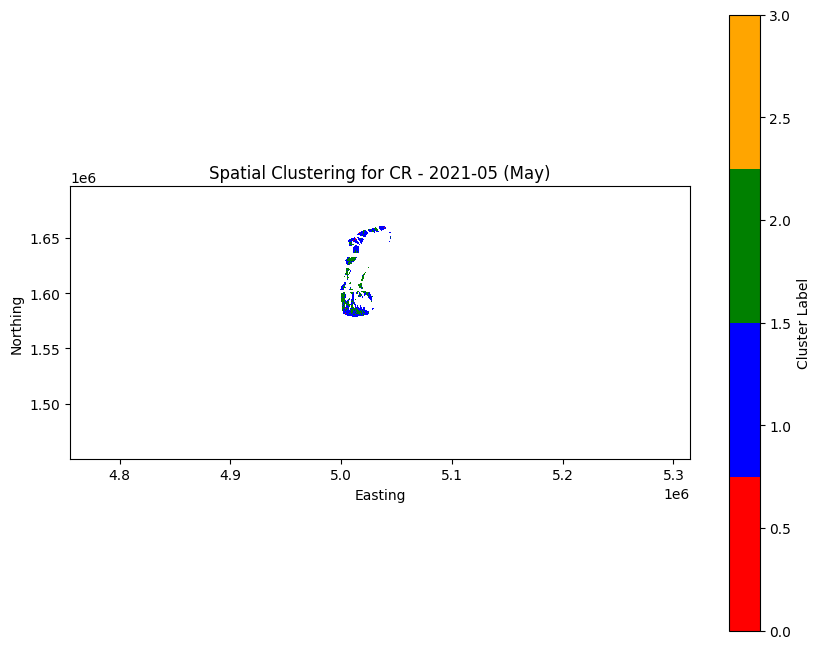

Spatial Clustering for VH - May 2022-05


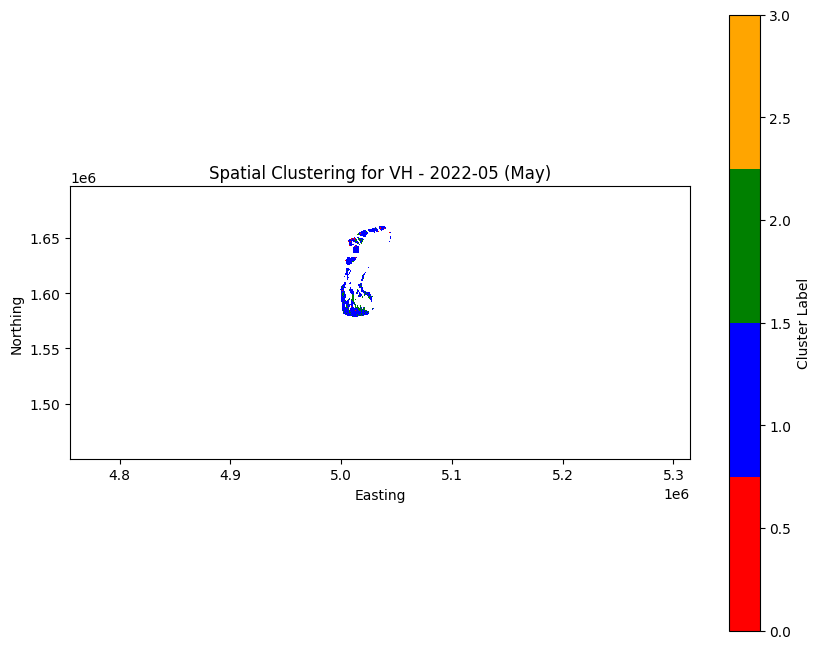

Spatial Clustering for VV - May 2022-05


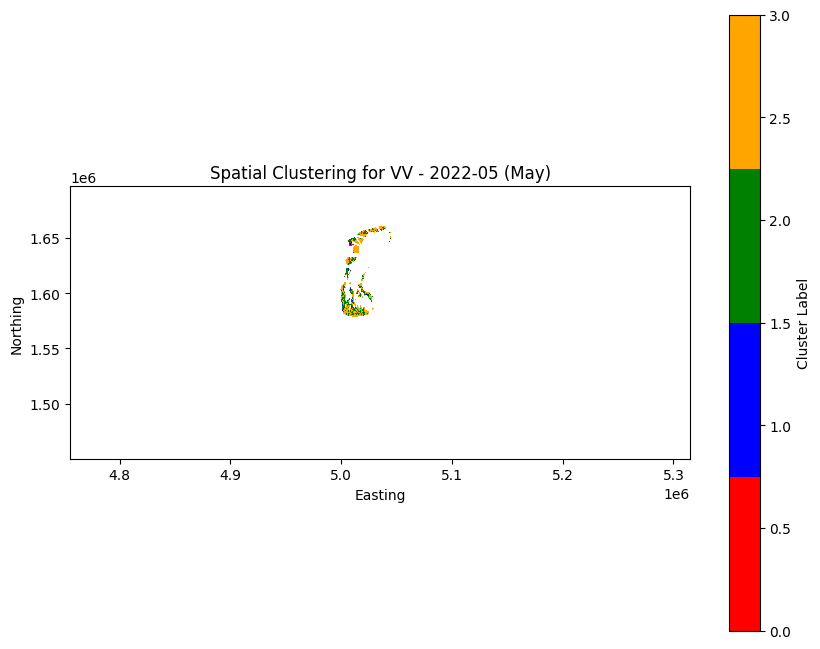

Spatial Clustering for CR - May 2022-05


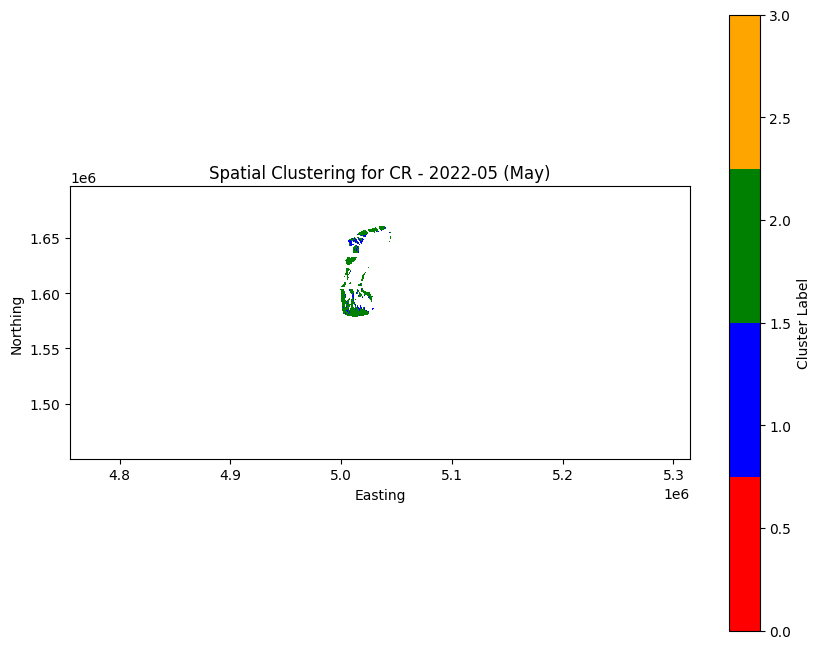

In [ ]:
may_indices = [1, 5, 9, 13]  # May for each of the 4 years. Indices go from 0 to 15

custom_cmap = ListedColormap(['red', 'blue', 'green', 'orange'])

def spatial_clustering_with_mask(series, time_step_index, reed_belt_geom, transform, n_clusters=4, title="Spatial Clustering"):
    # mask as in cell 6
    mask = geometry_mask(
        reed_belt_geom,
        transform=transform,
        invert=True,  
        out_shape=series[time_step_index].shape
    )

    data_masked = np.ma.masked_array(series[time_step_index], mask=~mask)

    data_flat = data_masked.compressed().reshape(-1, 1)
    if data_flat.size == 0:
        print("No data in the reed belt area.")
        return None

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_flat)
    labels = kmeans.labels_

    # Re-map the labels back to the spatial array
    labels_full = np.full(data_masked.shape, np.nan)  
    labels_full[~data_masked.mask] = labels  # clustering only to unmasked areas

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    plt.imshow(labels_full, cmap=custom_cmap, extent=(reed_belt.total_bounds[0], reed_belt.total_bounds[2],
                                                    reed_belt.total_bounds[1], reed_belt.total_bounds[3]))
    plt.title(f"{title} - {dates[time_step_index]} (May)")
    plt.colorbar(label="Cluster Label")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

    return labels_full

# Spatial clustering for may
reed_belt_geom = [reed_belt.geometry.iloc[0]]  
transform = rasterio.open(glob.glob(f"{tile_1_path}/*VV*.tif")[0]).transform  

for idx in may_indices:
    print(f"Spatial Clustering for VH - May {dates[idx]}")
    spatial_clustering_with_mask(vh_series, idx, reed_belt_geom, transform, n_clusters=4, title="Spatial Clustering for VH")

    print(f"Spatial Clustering for VV - May {dates[idx]}")
    spatial_clustering_with_mask(vv_series, idx, reed_belt_geom, transform, n_clusters=4, title="Spatial Clustering for VV")

    print(f"Spatial Clustering for CR - May {dates[idx]}")
    spatial_clustering_with_mask(cr_series, idx, reed_belt_geom, transform, n_clusters=4, title="Spatial Clustering for CR")


# 9

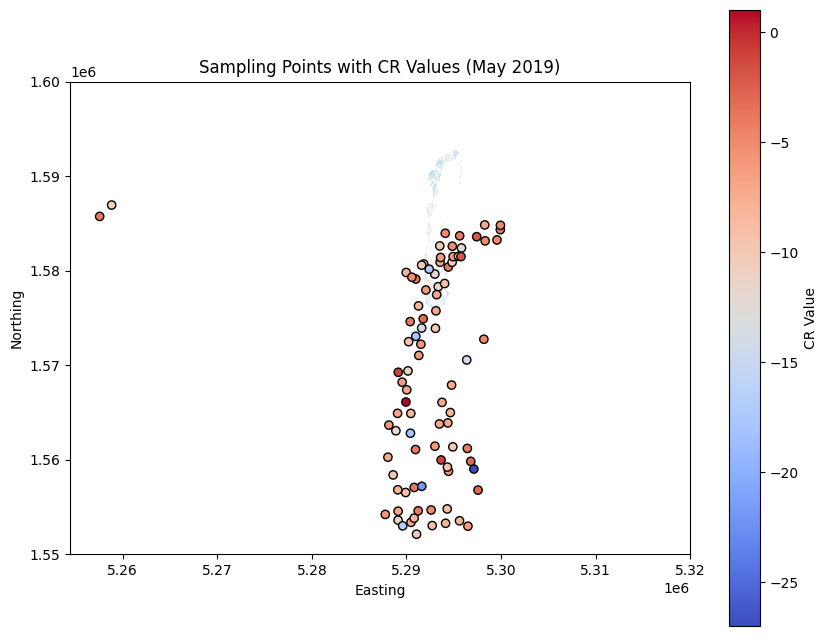

In [ ]:
# Filter out invalid sampling points
valid_points = [point for point in sampling_points.geometry if point is not None and not point.is_empty]

# Extract CR values for May 2019
cr_values_at_timestep = []
for point in valid_points:
    row, col = ~transform * (point.x, point.y)
    row, col = int(row), int(col)
    if 0 <= row < cr_series.shape[1] and 0 <= col < cr_series.shape[2]:
        cr_values_at_timestep.append(cr_series[1, row, col])  
    else:
        cr_values_at_timestep.append(np.nan)  

# Plot the masked CR raster with sampling points
plt.figure(figsize=(10, 8))
plt.imshow(cr_masked, cmap='RdBu', extent=[minx, maxx, miny, maxy])
plt.scatter(
    [point.x for point in valid_points],
    [point.y for point in valid_points],
    c=cr_values_at_timestep,  
    cmap='coolwarm',
    edgecolor='black'
)
plt.colorbar(label="CR Value")
plt.title("Sampling Points with CR Values (May 2019)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()
